## Preamble

### Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.dissimilarity import load_dmat_as_pickle
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import lib.thisproject.data

### Set Style

In [5]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 300
# NOTE: You can use the Chrome page inspector to make these large, presentable PNGs fit inside your notebook effectively, too.

# FIXME: Trying to make figures with Helvetica or Arial as the font, but apparently these aren't in available locations...?
plt.rcParams["font.sans-serif"] = [
    # "Helvetica",
    "DejaVu Sans",
    # "Bitstream Vera Sans",
    # "Computer Modern Sans Serif",
    # "Lucida Grande",
    # "Verdana",
    # "Geneva",
    # "Lucid",
    # "Arial",
    # "Avant Garde",
    # "sans-serif",
]

## Metadata

In [6]:
species_list = (
    pd.read_table("meta/species_group.tsv")[lambda x: x.species_group_id == "hmp2"]
    .species_id.astype(str)
    .unique()
)

In [7]:
def parse_taxonomy_string(taxonomy_string):
    values = taxonomy_string.split(";")
    return pd.Series(values, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])

In [8]:
species_taxonomy_inpath = "ref/uhgg_genomes_all_v2.tsv"

species_taxonomy = (
    pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]
    .assign(species_id=lambda x: "1" + x.MGnify_accession.str.split("-").str[2])
    .set_index("species_id")
    .Lineage.apply(parse_taxonomy_string)
)
species_taxonomy

/tmp/bsmith/ipykernel_930307/4268967817.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]


,d__,p__,c__,o__,f__,g__,s__
species_id,,,,,,,
100001,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__GCA-900066495,s__
100002,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Blautia_A,s__Blautia_A sp900066165
100003,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__Alistipes shahii
100004,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Anaerotruncus,s__Anaerotruncus colihominis
100005,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__Terrisporobacter,s__Terrisporobacter glycolicus_A
...,...,...,...,...,...,...,...
104640,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__
104641,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Sutterella,s__
104642,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__,g__,s__


p__Euryarchaeota (0.49999999999999956, 0.0, 1.0)
p__Thermoplasmatota (0.4762434743766357, 0.43561560482888373, 0.8118718682762947)
p__Firmicutes (0.13730663956330513, 0.48846903076532633, 1.0)
p__Firmicutes_A (0.2313124726048037, 0.5864780640600611, 0.6939374178144111)
p__Firmicutes_C (0.03269207045110534, 0.9999999999999998, 1.0)
p__Actinobacteriota (0.4723724756649227, 0.8241241585549742, 0.7293059019107313)
p__Synergistota (0.5039025959761778, 1.0, 0.7049219497439101)
p__Fusobacteriota (0.7159995965199522, 0.8931657578847765, 0.6794972736543294)
p__Campylobacterota (0.9433756729740642, 1.0, 0.3660254037844388)
p__Proteobacteria (0.8446027625105776, 0.6948742813072231, 0.5338082875317327)
p__Desulfobacterota_A (0.9999999999999999, 0.49465584339977886, 0.25584277759443574)
p__Bacteroidota (0.7822498041325509, 0.4101711929297688, 0.34674941239765256)
p__Verrucomicrobiota (1.0, 0.0, 0.0)


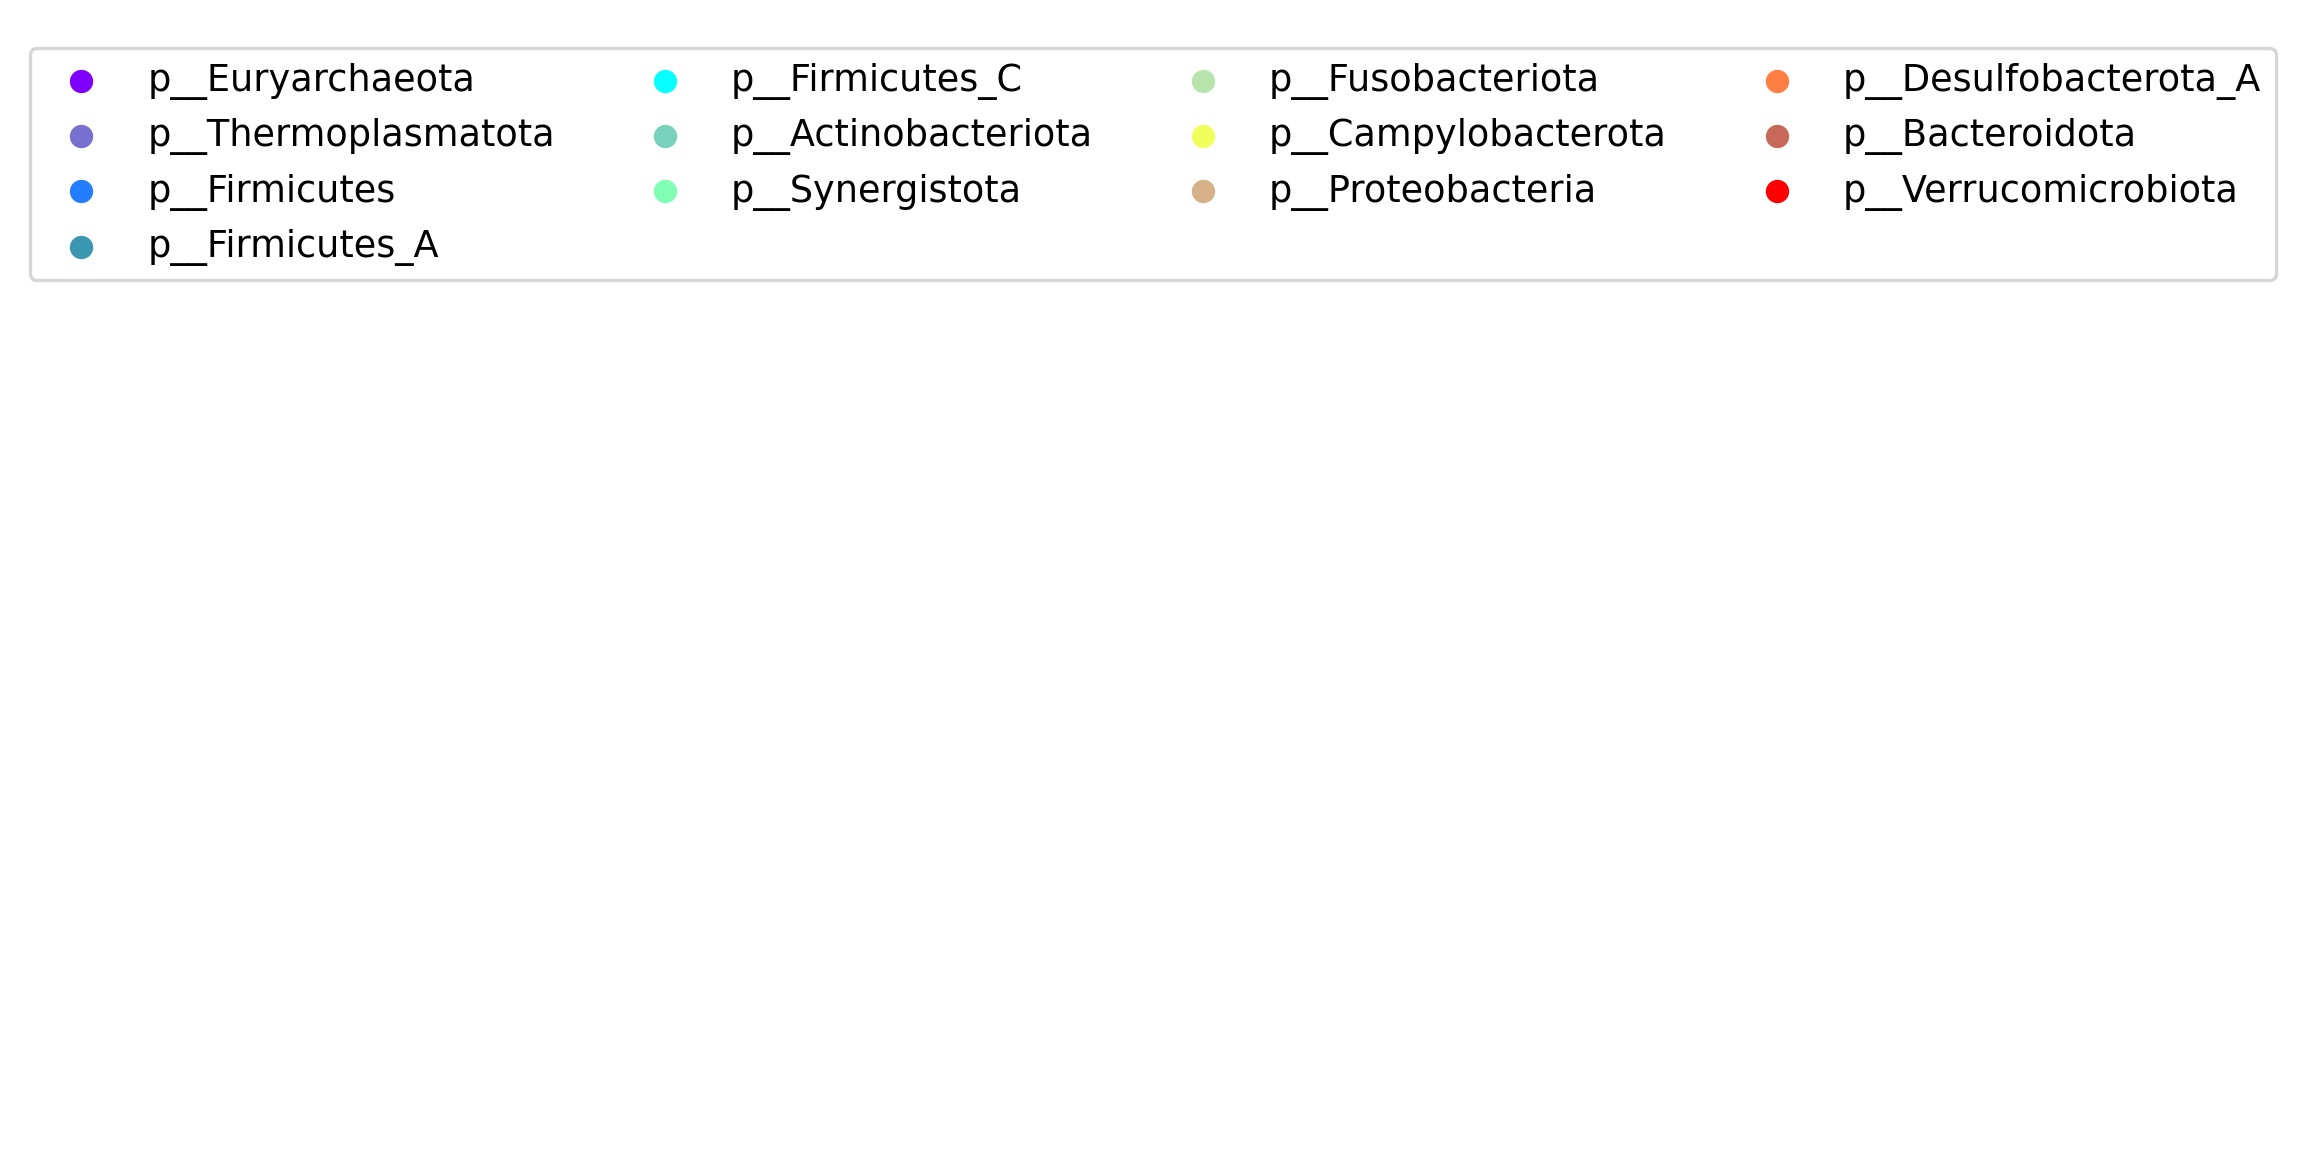

In [9]:
phylum_order = [
    "p__Euryarchaeota",
    "p__Thermoplasmatota",
    "p__Firmicutes",
    "p__Firmicutes_A",
    "p__Firmicutes_C",
    # "p__Firmicutes_B", # None in species_list1
    # "p__Firmicutes_G", # B/G/I not sure how related to C or A
    # "p__Firmicutes_I", #
    # "p__Cyanobacteria", # None in species_list1
    "p__Actinobacteriota",
    "p__Synergistota",
    "p__Fusobacteriota",
    "p__Campylobacterota",
    "p__Proteobacteria",
    "p__Desulfobacterota_A",
    "p__Bacteroidota",
    "p__Verrucomicrobiota",
    # "dummy0", # 18
    # "dummy1", # 19
    # "dummy2", # 20
]

phylum_palette = lib.plot.construct_ordered_palette(
    phylum_order,
    cm="rainbow",
    desaturate_levels=[1.0, 0.5],
)

for p__ in phylum_order:
    print(p__, phylum_palette[p__])
    plt.scatter([], [], color=phylum_palette[p__], label=p__)
plt.legend(ncols=4)
lib.plot.hide_axes_and_spines()

# assert len(set(phylum_palette.values())) == len((phylum_palette.values()))

In [10]:
def classify_genome(x):
    if (x.genome_type == "Isolate") & x.passes_filter:
        return "isolate"
    elif (x.genome_type == "Isolate") & ~x.passes_filter:
        return "isolate_fails_qc"
    elif (x.genome_type == "MAG") & x.passes_filter:
        return "mag"
    elif (x.genome_type == "MAG") & ~x.passes_filter:
        return "mag_fails_qc"
    elif (x.genome_type == "SPGC") & x.passes_filter:
        return "spgc"
    elif (x.genome_type == "SPGC") & x.passes_geno_positions:
        return "sfacts_only"
    elif (x.genome_type == "SPGC") & ~(x.passes_geno_positions):
        return "sfacts_fails_qc"
    else:
        raise ValueError("Genome did not match classification criteria:", x)

In [11]:
filt_stats = []
missing_species = []

_species_list = species_list
# _species_list = ["100003"]

for species in tqdm(_species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        continue
    data = pd.read_table(inpath).assign(species=species, inpath=inpath)
    filt_stats.append(data)
filt_stats = (
    pd.concat(filt_stats)
    .assign(
        genome_class=lambda x: x.apply(classify_genome, axis=1),
        species_strain=lambda x: x.species + "_" + x.genome_id,
    )
    .set_index("species_strain")
)


print(
    len(missing_species),
    "out of",
    len(_species_list),
    "species are missing stats.",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:06<00:00, 100.99it/s]


11 out of 627 species are missing stats.


In [12]:
# Define different subsets of the species:

# All species:
# species_list
spgc_strain_list = filt_stats[lambda x: x.genome_type.isin(["SPGC"])].index.values

# All species with enough positions
species_list0 = filt_stats[lambda x: x.passes_geno_positions].species.unique()
spgc_strain_list0 = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list0)
].index.values

# All species with sf strains
species_list1 = filt_stats[
    lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
].species.unique()
spgc_strain_list1 = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list1)
].index.values

# All species with sf strains to talk about distributions (>=10)
species_list1b = idxwhere(
    filt_stats[
        lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 10
)
spgc_strain_list1b = filt_stats[
    lambda x: x.passes_geno_positions
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list1b)
].index.values

# All species with spgc strains
species_list2 = filt_stats[
    lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
].species.unique()
spgc_strain_list2 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list2)
].index.values

# All species with enough spgc strains for pangenome analysis (>=10)
species_list3 = idxwhere(
    filt_stats[
        lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 10
)
spgc_strain_list3 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list3)
].index.values

# Species with large numbers of strains (>=20)
species_list4 = idxwhere(
    filt_stats[
        lambda x: x.passes_filter & x.genome_type.isin(["SPGC"])
    ].species.value_counts()
    >= 20
)
spgc_strain_list4 = filt_stats[
    lambda x: x.passes_filter
    & x.genome_type.isin(["SPGC"])
    & x.species.isin(species_list4)
].index.values

_species_list_map = {
    "All considered species": (species_list, spgc_strain_list),
    "0: Species with enough genotyped positions": (species_list0, spgc_strain_list0),
    "1: With sfacts strains": (species_list1, spgc_strain_list1),
    "1b: With (>=10) sfacts strains": (species_list1b, spgc_strain_list1b),
    "2: With SPGC inferences": (species_list2, spgc_strain_list2),
    "3: With >=10 inferences": (species_list3, spgc_strain_list3),
    "4: With >=20 inferences": (species_list4, spgc_strain_list4),
}
for _species_list_name, (_species_list, _strain_list) in _species_list_map.items():
    print(_species_list_name, len(_species_list), len(_strain_list))
    print(species_taxonomy.loc[_species_list].p__.value_counts())
    print()

All considered species 627 11264
p__
p__Firmicutes_A          310
p__Bacteroidota           97
p__Firmicutes             77
p__Proteobacteria         45
p__Actinobacteriota       40
p__Firmicutes_C           32
p__Verrucomicrobiota      10
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Spirochaetota           1
p__Campylobacterota        1
Name: count, dtype: int64

0: Species with enough genotyped positions 616 10962
p__
p__Firmicutes_A          308
p__Bacteroidota           97
p__Firmicutes             76
p__Proteobacteria         45
p__Actinobacteriota       34
p__Firmicutes_C           31
p__Verrucomicrobiota      10
p__Desulfobacterota_A      5
p__Fusobacteriota          3
p__Synergistota            2
p__Thermoplasmatota        2
p__Euryarchaeota           2
p__Campylobacterota        1
Name: count, dtype: int64

1: With sfacts strains 601 10962
p__
p__Firmicutes_A          304
p__

## Analysis

## Higher rate of KEGG Module and Plasmid/Phage matching in clusters

In [13]:
clust = []
kegg_module = []
cog_category = []
plasmid = []
phage = []

for species in tqdm(species_list4):
    clust_inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.uhgg-strain_gene.gene_clust-t10.tsv"
    kegg_module_inpath = (
        f"data/species/sp-{species}/midasdb_v20.emapper.gene75_x_kegg_module.tsv"
    )
    cog_category_inpath = (
        f"data/species/sp-{species}/midasdb_v20.emapper.gene75_x_cog_category.tsv"
    )
    plasmid_inpath = (
        f"data/species/sp-{species}/midasdb_v20.gene75_x_genomad_plasmid.tsv"
    )
    phage_inpath = f"data/species/sp-{species}/midasdb_v20.gene75_x_genomad_virus.tsv"
    clust.append(
        pd.read_table(clust_inpath, names=["centroid_75", "clust"]).assign(
            species=species
        )
    )
    kegg_module.append(pd.read_table(kegg_module_inpath))
    cog_category.append(pd.read_table(cog_category_inpath))
    plasmid.append(pd.read_table(plasmid_inpath))
    phage.append(pd.read_table(phage_inpath))

clust = pd.concat(clust).assign(
    clust_label=lambda x: x.clust.astype(str) + "_" + x.species
)
kegg_module = pd.concat(kegg_module)
cog_category = pd.concat(cog_category)
plasmid = pd.concat(plasmid)
phage = pd.concat(phage)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.28it/s]


In [14]:
# How many clusters (with >=2 genes)?
clust[lambda x: (x.clust >= 0)].clust_label.value_counts()[lambda x: x > 1]

clust_label
4546_102492    546
2671_103694    532
3196_102478    401
3195_102478    369
5055_102478    361
              ... 
338_100022       2
1867_102528      2
4294_100099      2
3076_102492      2
645_104158       2
Name: count, Length: 36208, dtype: int64

In [15]:
# Median number of clusters per species.
clust[lambda x: (x.clust >= 0)].groupby("species").clust_label.value_counts()[
    lambda x: x > 1
].reset_index().species.value_counts().median()

681.5

### Figure 4D

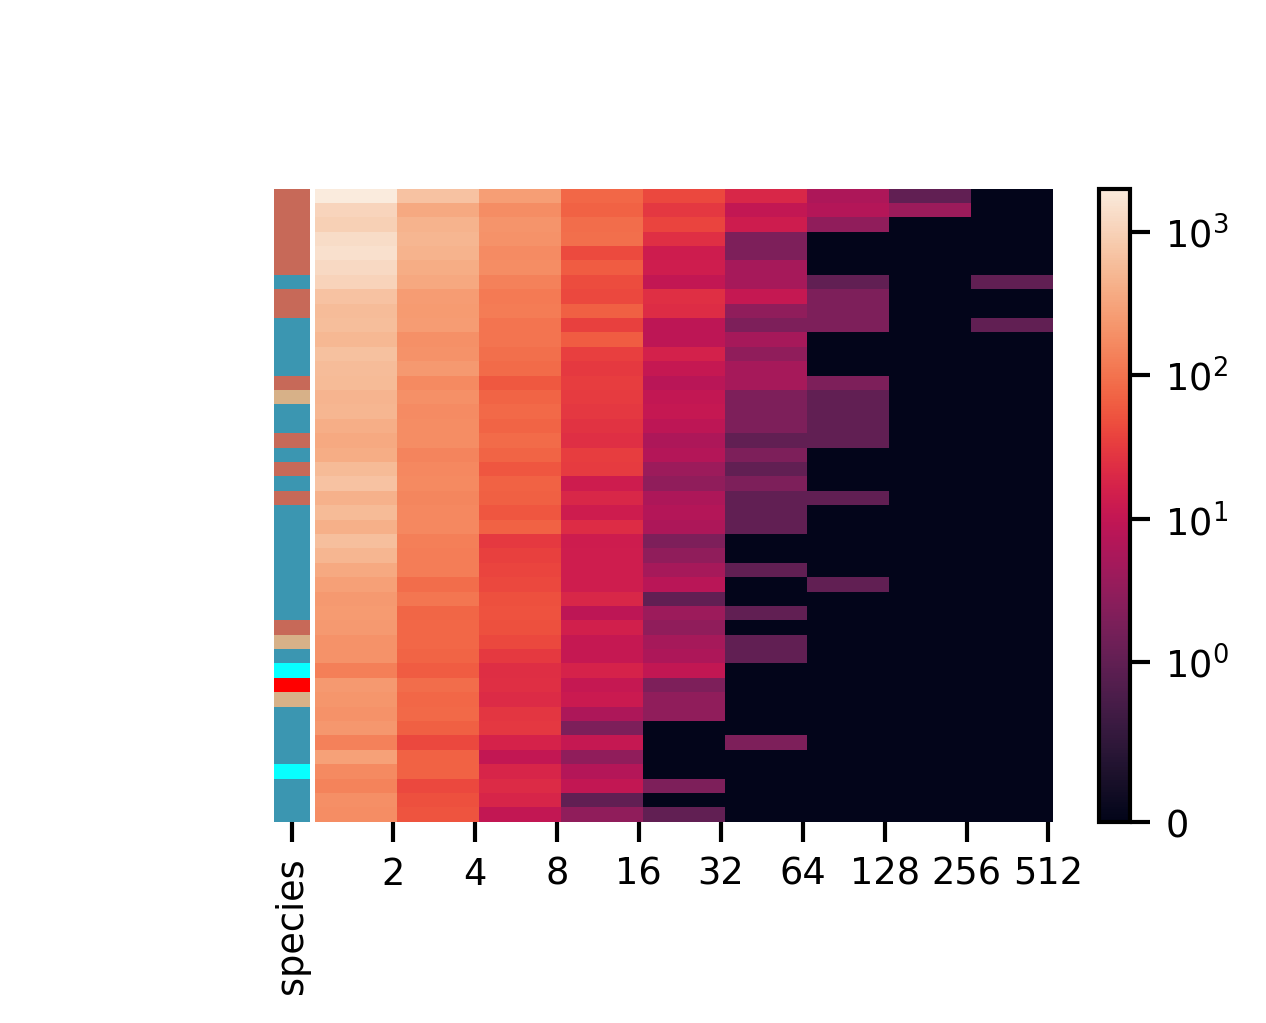

In [16]:
bins = np.array([2**i for i in range(1, 11)])

d = (
    clust[lambda x: x.clust >= 0]
    .groupby("species")
    .apply(
        lambda d: pd.Series(
            np.histogram(d.clust_label.value_counts(), bins=bins)[0], index=bins[:-1]
        )
    )
)
# Order by total number of genes in clusters with size ≥2
species_order = (
    (
        clust[lambda x: x.clust >= 0][["species", "clust"]].value_counts()[
            lambda x: x > 1
        ]
    )
    .groupby("species")
    .sum()
    .sort_values(ascending=False)
    .index
)

row_colors = (
    d.index.to_series().map(species_taxonomy.p__).map(phylum_palette)  # .rename("")
)

norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=2_000)
cmap = sns.color_palette("rocket", as_cmap=True)

cg = sns.clustermap(
    d.loc[species_order].drop(columns=[1], errors="ignore"),
    norm=norm,
    cmap=cmap,
    xticklabels=1,
    yticklabels=0,
    col_cluster=False,
    row_cluster=False,
    row_colors=row_colors,
    figsize=(4.5, 3.5),
    cbar_pos=None,
)
cg.ax_heatmap.set_ylabel("")
cg.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=cg.ax_heatmap)
cg.ax_heatmap.set_xticks(
    ticks=np.array(cg.ax_heatmap.get_xticks()) + 0.45, labels=d.columns, rotation=0
)

plt.savefig('fig/fig4d_cluster_size.pdf', bbox_inches='tight')

In [17]:
non_singleton_clusters = idxwhere(
    (clust[lambda x: x.clust >= 0].clust_label.value_counts() > 1)
)
len(non_singleton_clusters)

36208

### KEGG Modules

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


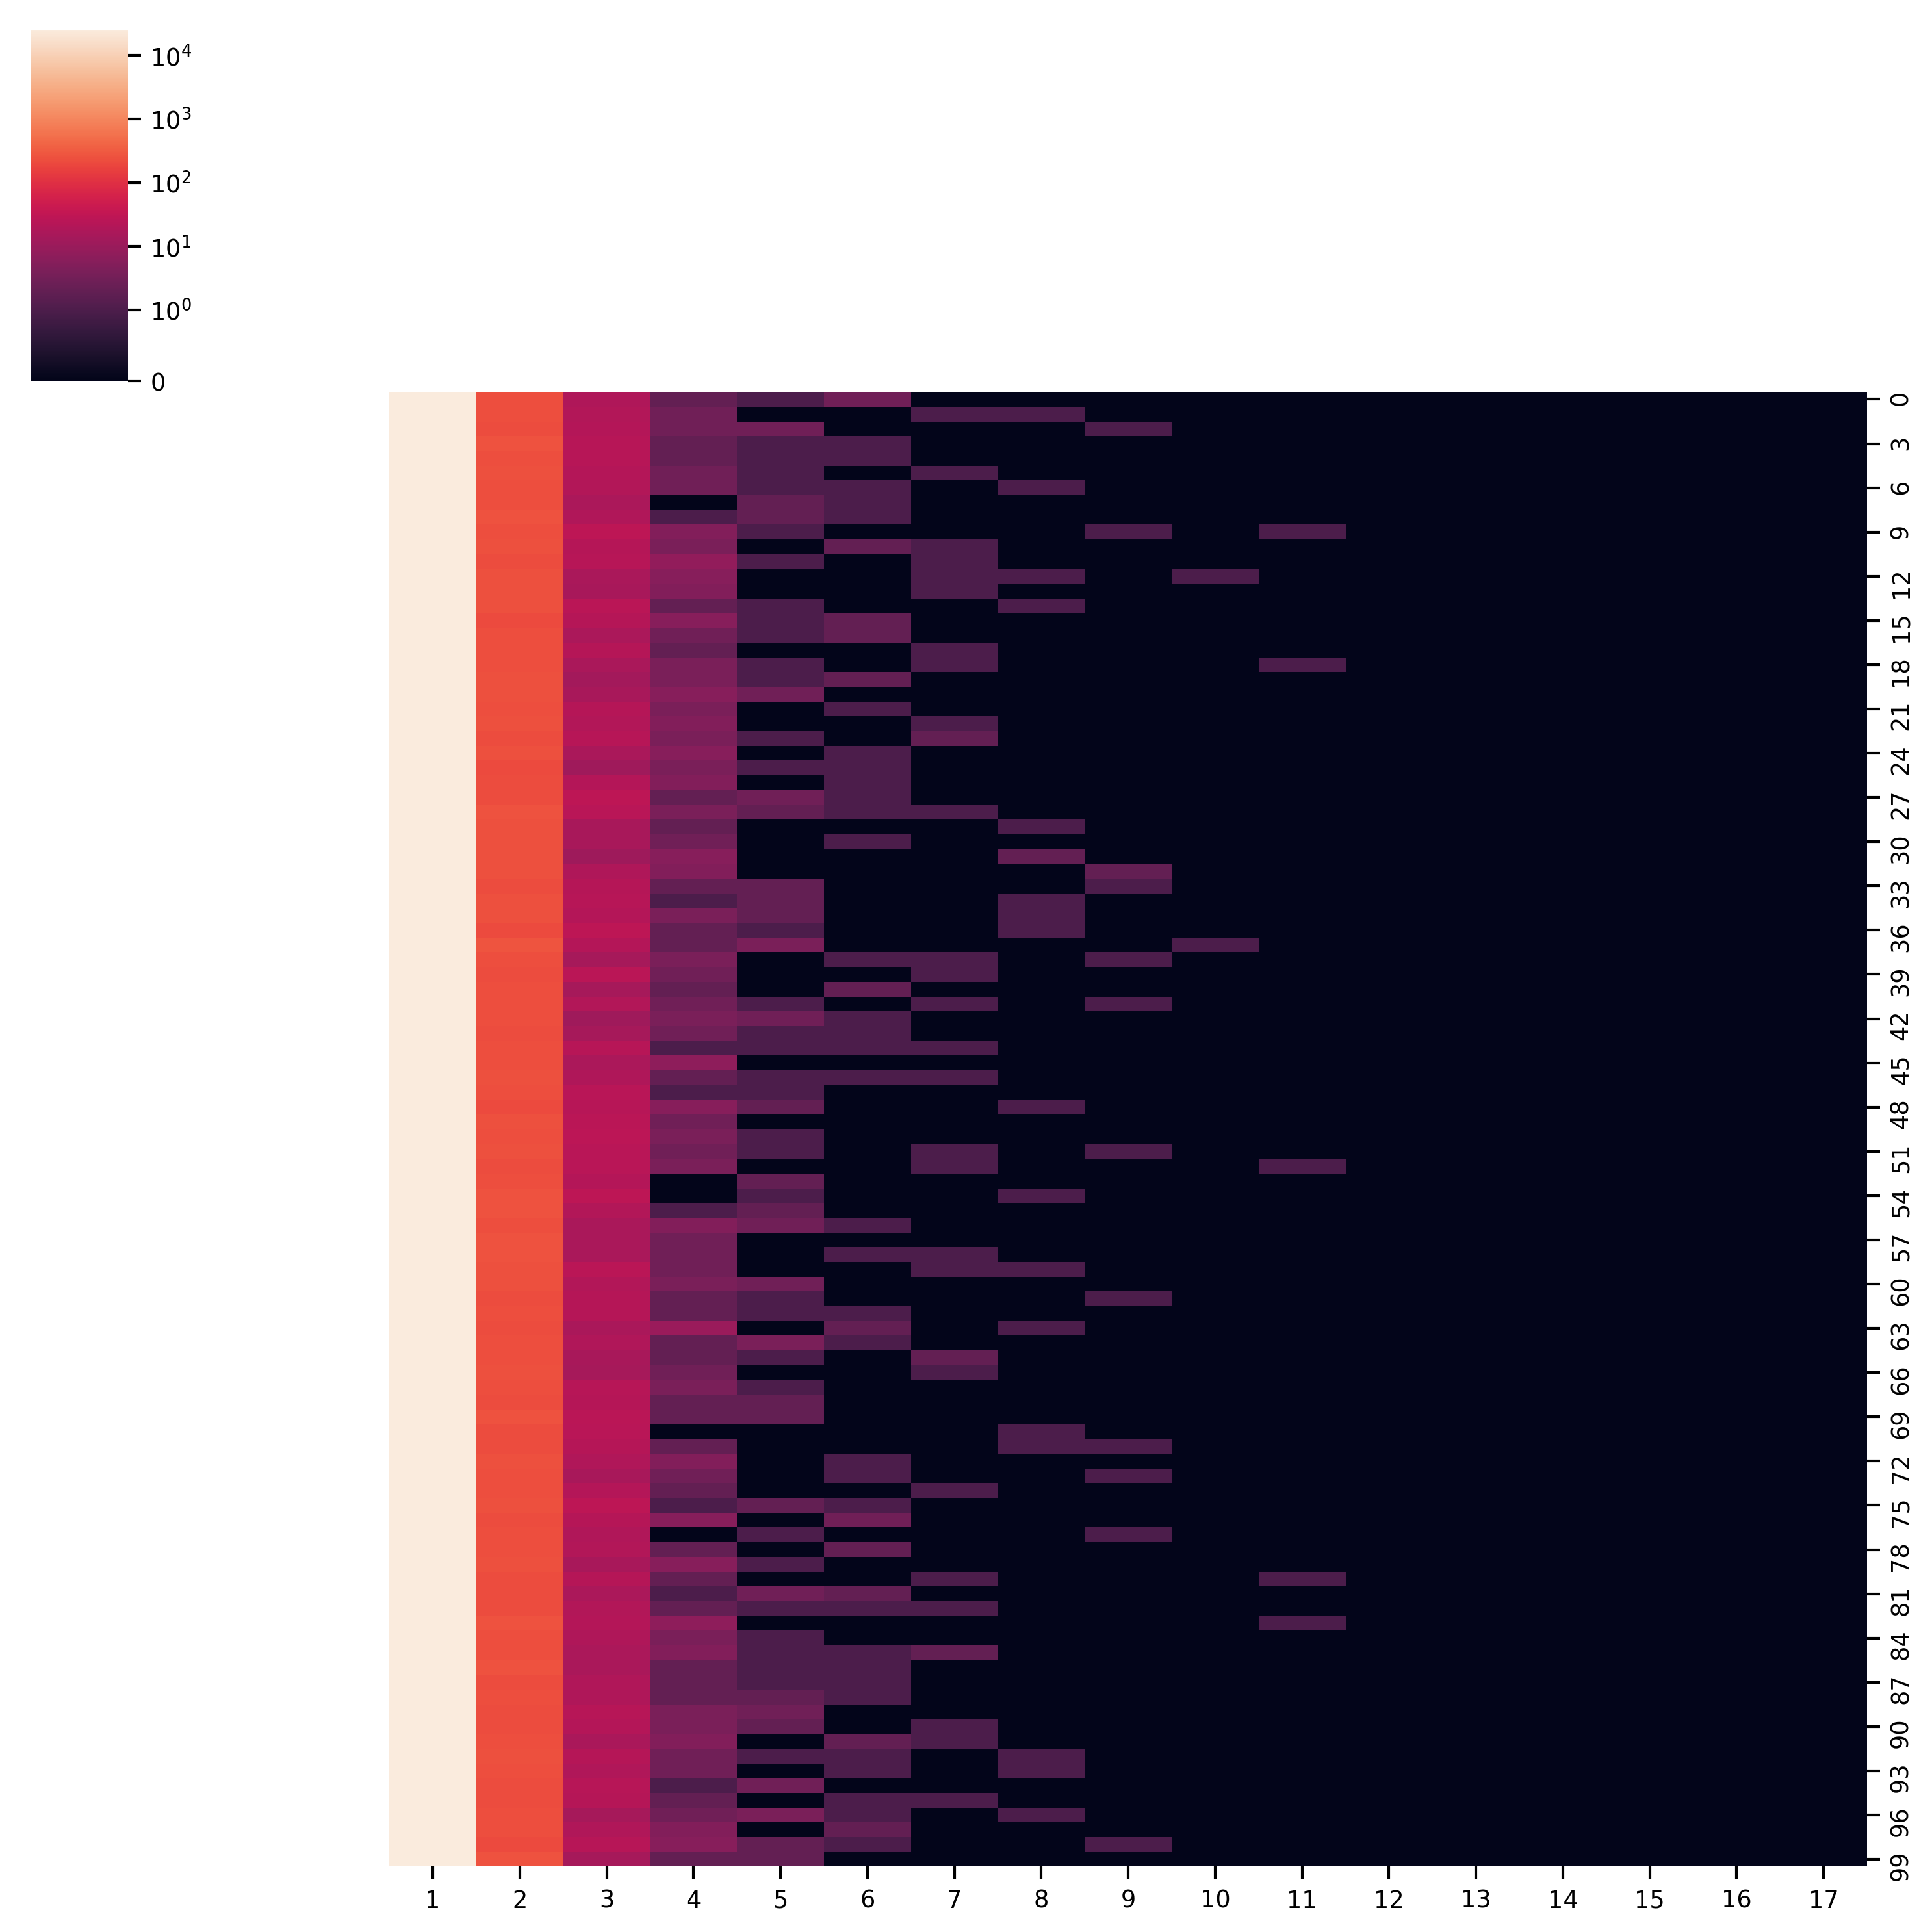

In [18]:
_annot = kegg_module.rename(columns={"kegg_module": "annot"})

all_counted_genes_clust_info = clust[lambda x: x.clust > 0]
obs_clust_annot_count = (
    pd.merge(all_counted_genes_clust_info, _annot, on="centroid_75", how="left")[
        ["clust_label", "annot"]
    ]
    .value_counts()
    .groupby("clust_label")
    .max()
)

np.random.seed(0)
n_perm = 100
perm_clust_annot_count_list = []
for i in tqdm(range(n_perm)):
    perm_clust_annot_count = (
        pd.merge(
            all_counted_genes_clust_info.groupby("species").apply(
                lambda d: d.assign(
                    clust_label=lambda x: x.clust_label.sample(frac=1).values
                )
            ),
            _annot,
            on="centroid_75",
            how="left",
        )[["clust_label", "annot"]]
        .value_counts()
        .groupby("clust_label")
        .max()
    )
    perm_clust_annot_count_list.append(perm_clust_annot_count)


bins = np.arange(obs_clust_annot_count.max()) + 1

perm_histogram2d = pd.DataFrame(
    np.stack(
        [
            np.histogram(perm_clust_annot_count, bins=bins)[0]
            for perm_clust_annot_count in perm_clust_annot_count_list
        ]
    ),
    columns=bins[:-1],
)
obs_histogram = pd.Series(
    np.histogram(obs_clust_annot_count, bins=bins)[0], index=bins[:-1]
)
sns.clustermap(
    perm_histogram2d,
    norm=mpl.colors.SymLogNorm(linthresh=1),
    row_cluster=False,
    col_cluster=False,
)

kegg_module_bins = bins
kegg_module_perm_clust_annot_count = perm_clust_annot_count
kegg_module_obs_clust_annot_count = obs_clust_annot_count
kegg_module_perm_histogram2d = perm_histogram2d
kegg_module_obs_histogram = obs_histogram

### Figure 4E

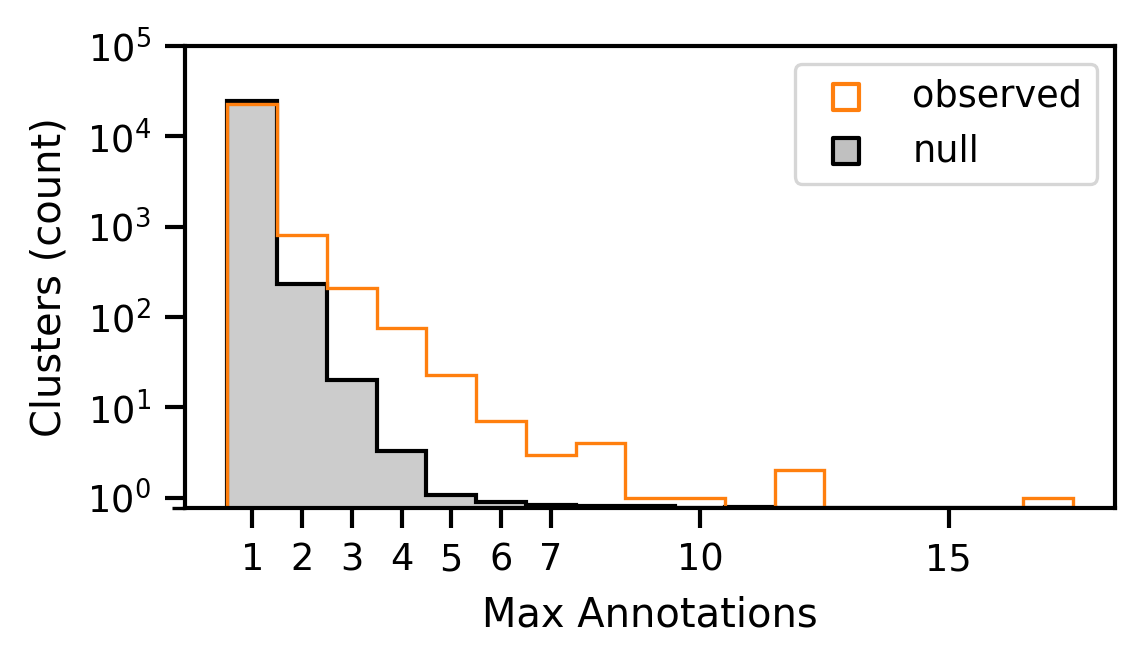

In [19]:
fig, ax = plt.subplots(figsize=(4, 2))

_perm = kegg_module_perm_histogram2d
_obs = kegg_module_obs_clust_annot_count
_bins = kegg_module_bins

# # Plot the permutation histograms
# for perm_clust_annot_count in perm_clust_annot_count_list:
#     ax.hist(perm_clust_annot_count, bins=bins, align='left', color='k', alpha=0.5 / n_perm)
# # Plot the expected values.
# ax.stairs(perm_histogram2d.mean(0), bins - 0.5, edgecolor='k', facecolor='none', lw=1)

# Plot the mean
ax.stairs(
    _perm.mean(0),
    _bins - 0.5,
    edgecolor="none",
    facecolor="k",
    lw=1,
    fill=True,
    alpha=0.2,
)
ax.stairs(
    _perm.mean(0),
    _bins - 0.5,
    edgecolor="k",
    facecolor="none",
    lw=1,
    fill=True,
    alpha=1.0,
)

# ax.hist(perm_histogram2d.mean(0), bins=bins, align='left', color='k', alpha=0.5)
# ax.hist(perm_histogram2d.mean(0), bins=bins, align='left', color='k', histtype='step')

ax.hist(_obs, bins=_bins, align="left", histtype="step", color="tab:orange")
# ax.hist(obs_clust_annot_count, bins=bins, align='left', histtype="stepfilled", color='tab:orange', alpha=0.2)
ax.set_yscale("symlog", linthresh=1, linscale=0.1)

ax.scatter(
    [],
    [],
    edgecolor="tab:orange",
    facecolor="none",
    lw=1,
    label="observed",
    marker="s",
    s=40,
)
ax.scatter(
    [], [], edgecolor="k", facecolor="silver", label="null", marker="s", s=40, lw=1
)
ax.legend(loc="upper right")

ax.set_xticks(
    np.concatenate([np.arange(1, 8, step=1), np.arange(10, _obs.max() + 1, step=5)])
)
ax.set_xlabel("Max Annotations")
ax.set_ylabel("Clusters (count)")
ax.set_ylim(0, 1e5)
ax.set_yticks(np.logspace(0, 5, num=6))

fig.savefig('fig/fig4e_kegg_mod_enrichment.pdf', bbox_inches='tight')

,obs,perm,ratio
1,23899,24635.21,0.970116
2,1142,256.77,4.447560
3,329,25.70,12.801556
4,118,5.62,20.996441
5,42,2.37,17.721519
6,19,1.31,14.503817
7,12,0.71,16.901408
8,9,0.39,23.076923
9,5,0.20,25.000000
10,4,0.07,57.142857


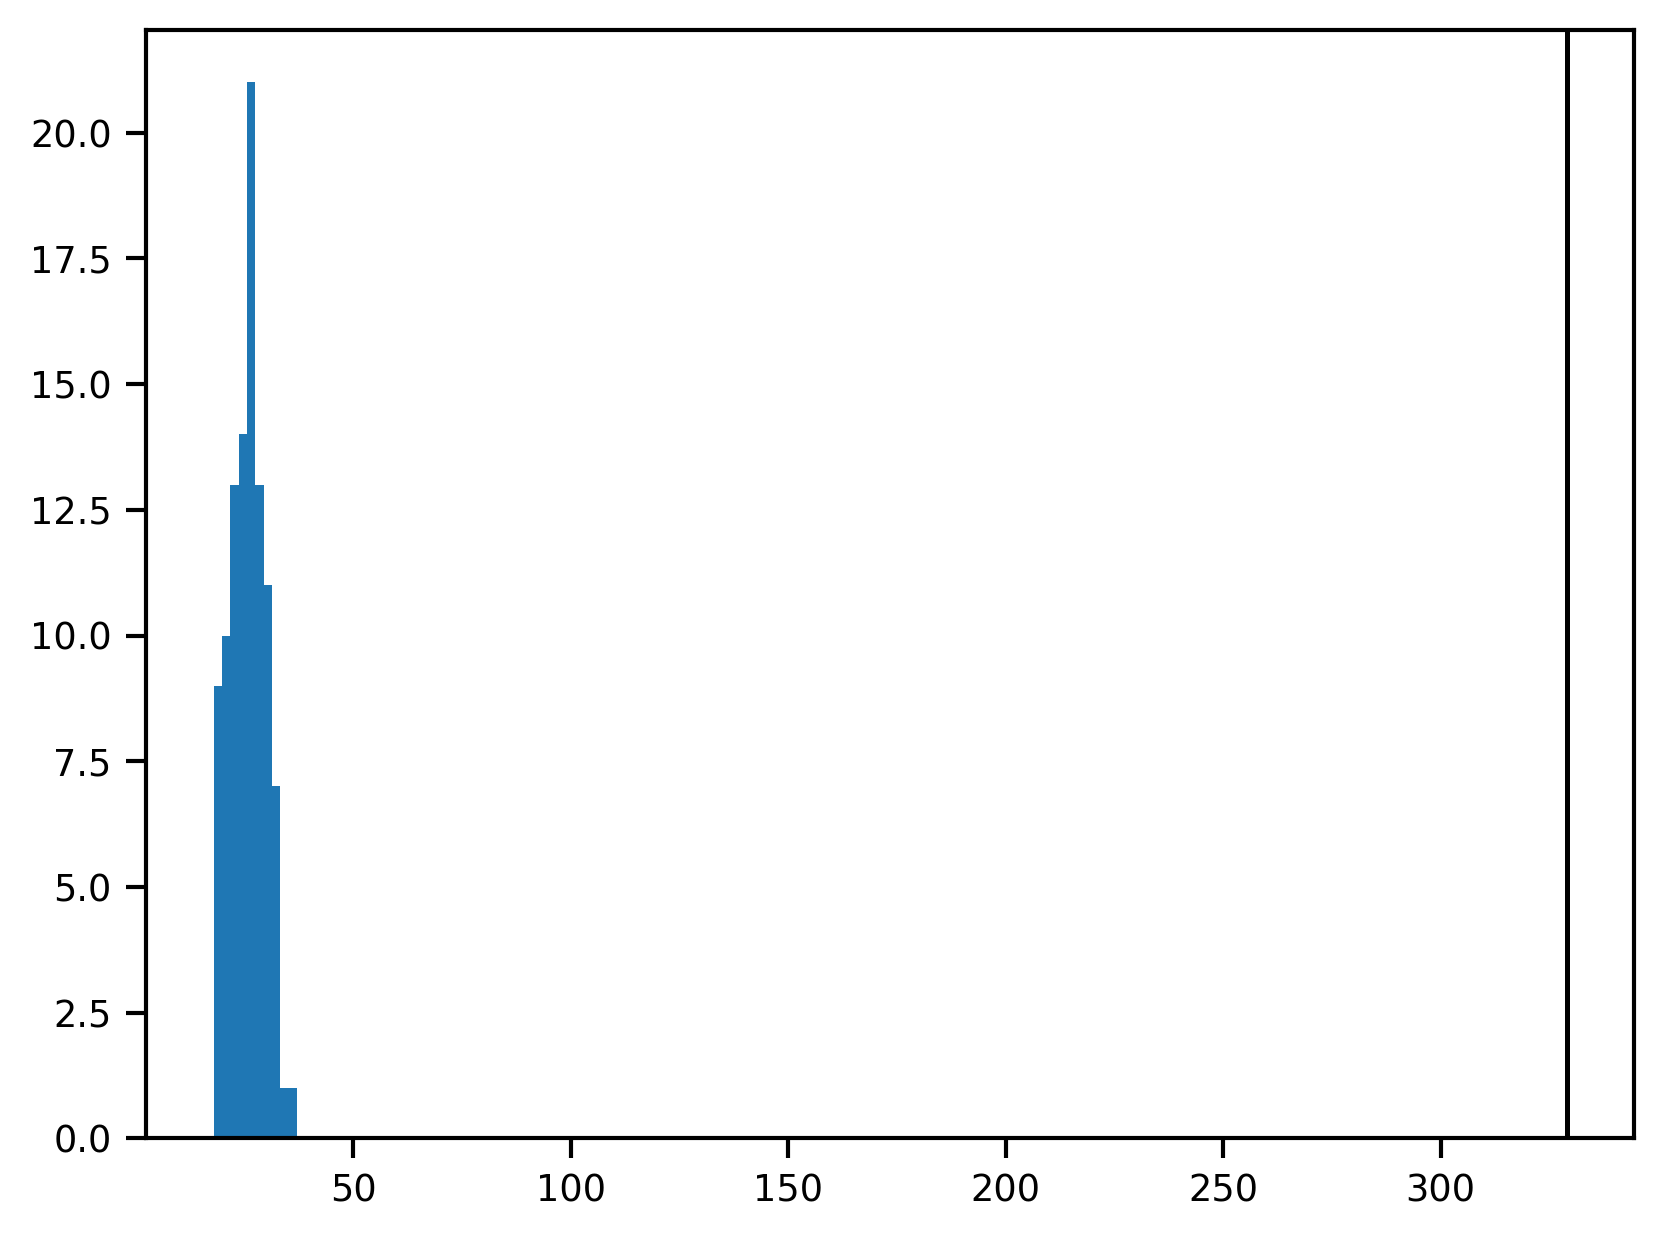

In [20]:
_perm = kegg_module_perm_histogram2d
_obs = kegg_module_obs_histogram

obs_num_clust_ge3 = _obs.iloc[::-1].cumsum().loc[3]
null_num_clust_ge3 = _perm.iloc[:, ::-1].cumsum(1)[3]

plt.hist(null_num_clust_ge3)
plt.axvline(obs_num_clust_ge3, color="k")

d = pd.DataFrame(
    dict(
        obs=_obs.iloc[::-1].cumsum().iloc[::-1],
        perm=_perm.iloc[:, ::-1].cumsum(1).iloc[:, ::-1].mean(),
    )
).assign(ratio=lambda x: x.obs / x.perm)
d

### Plasmid / Phage

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.28it/s]


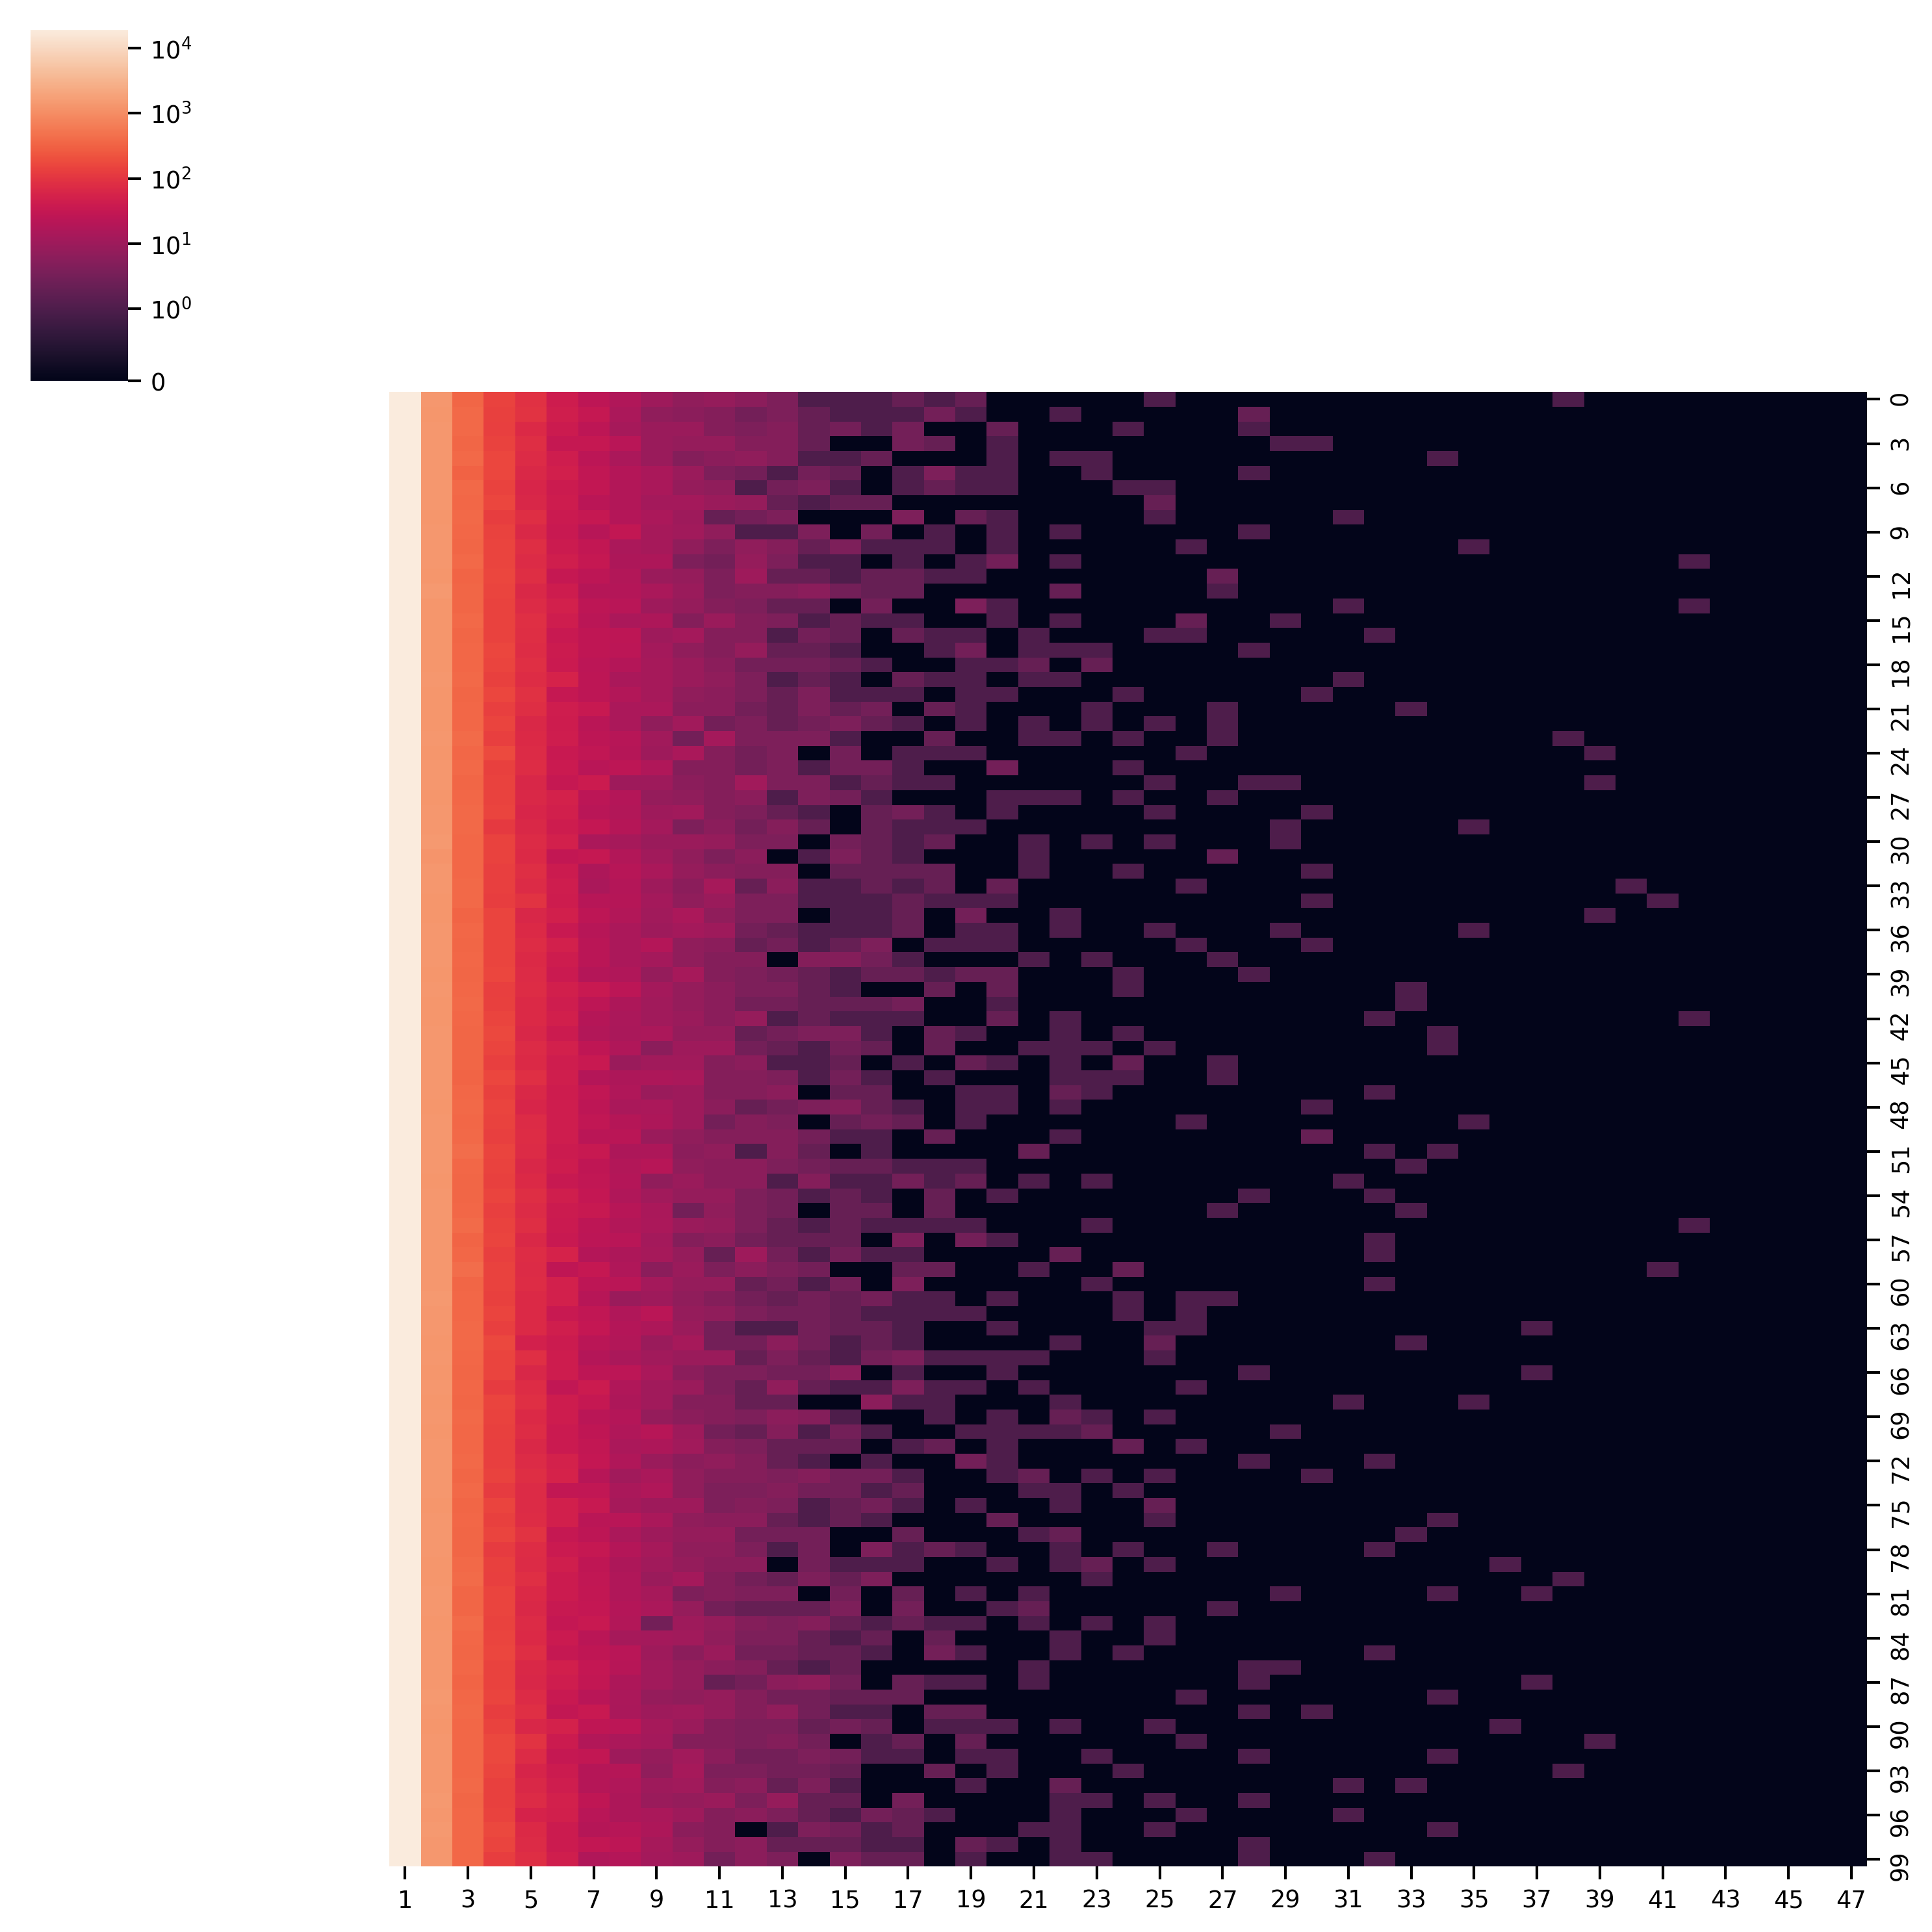

In [21]:
_annot = (
    pd.DataFrame(
        dict(
            phage=phage.assign(phage=True)[["centroid_75", "phage"]]
            .drop_duplicates()
            .set_index("centroid_75")
            .phage,
            plasmid=plasmid.assign(plasmid=True)[["centroid_75", "plasmid"]]
            .drop_duplicates()
            .set_index("centroid_75")
            .plasmid,
        )
    )
    .stack()
    .sort_values()
    .rename_axis(["centroid_75", "annot"])
    .reset_index()
    .drop(columns=[0])
)

all_counted_genes_clust_info = clust[lambda x: x.clust > 0]
obs_clust_annot_count = (
    pd.merge(all_counted_genes_clust_info, _annot, on="centroid_75", how="left")[
        ["clust_label", "annot"]
    ]
    .value_counts()
    .groupby("clust_label")
    .max()
)

np.random.seed(0)
n_perm = 100
perm_clust_annot_count_list = []
for i in tqdm(range(n_perm)):
    perm_clust_annot_count = (
        pd.merge(
            all_counted_genes_clust_info.groupby("species").apply(
                lambda d: d.assign(
                    clust_label=lambda x: x.clust_label.sample(frac=1).values
                )
            ),
            _annot,
            on="centroid_75",
            how="left",
        )[["clust_label", "annot"]]
        .value_counts()
        .groupby("clust_label")
        .max()
    )
    perm_clust_annot_count_list.append(perm_clust_annot_count)


bins = np.arange(obs_clust_annot_count.max()) + 1

perm_histogram2d = pd.DataFrame(
    np.stack(
        [
            np.histogram(perm_clust_annot_count, bins=bins)[0]
            for perm_clust_annot_count in perm_clust_annot_count_list
        ]
    ),
    columns=bins[:-1],
)
obs_histogram = pd.Series(
    np.histogram(obs_clust_annot_count, bins=bins)[0], index=bins[:-1]
)
sns.clustermap(
    perm_histogram2d,
    norm=mpl.colors.SymLogNorm(linthresh=1),
    row_cluster=False,
    col_cluster=False,
)

plasmid_phage_bins = bins
plasmid_phage_perm_clust_annot_count = perm_clust_annot_count
plasmid_phage_obs_clust_annot_count = obs_clust_annot_count
plasmid_phage_perm_histogram2d = perm_histogram2d
plasmid_phage_obs_histogram = obs_histogram

### Figure 4F

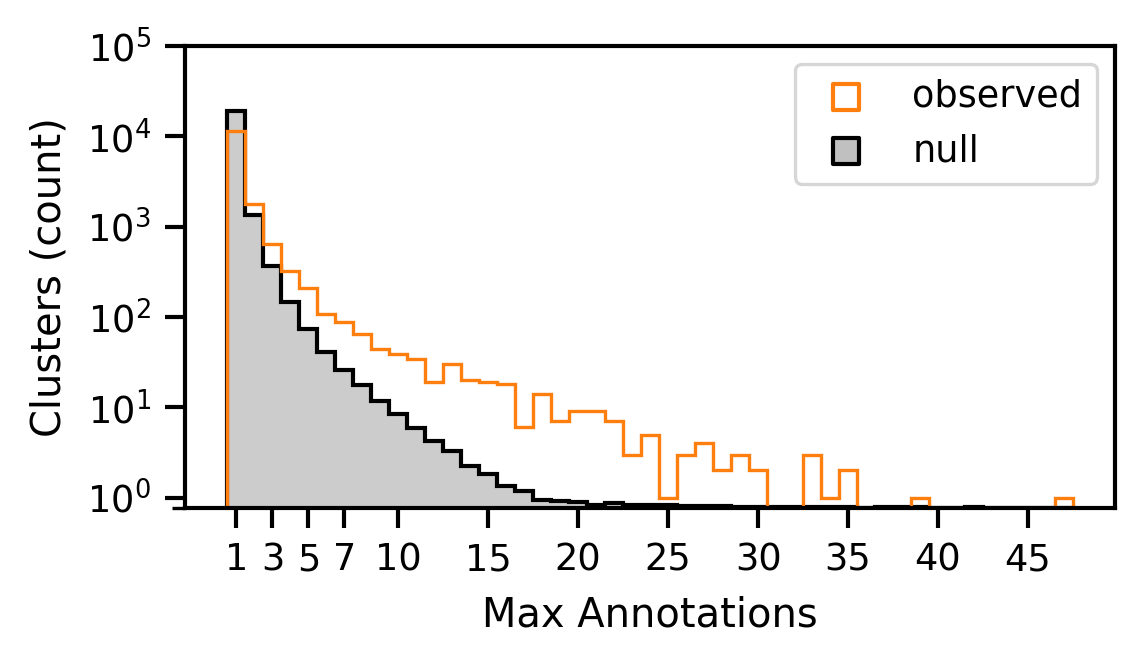

In [22]:
fig, ax = plt.subplots(figsize=(4, 2))

_perm = plasmid_phage_perm_histogram2d
_obs = plasmid_phage_obs_clust_annot_count
_bins = plasmid_phage_bins

# # Plot the permutation histograms
# for perm_clust_annot_count in perm_clust_annot_count_list:
#     ax.hist(perm_clust_annot_count, bins=bins, align='left', color='k', alpha=0.5 / n_perm)
# # Plot the expected values.
# ax.stairs(perm_histogram2d.mean(0), bins - 0.5, edgecolor='k', facecolor='none', lw=1)

# Plot the mean
ax.stairs(
    _perm.mean(0),
    _bins - 0.5,
    edgecolor="none",
    facecolor="k",
    lw=1,
    fill=True,
    alpha=0.2,
)
ax.stairs(
    _perm.mean(0),
    _bins - 0.5,
    edgecolor="k",
    facecolor="none",
    lw=1,
    fill=True,
    alpha=1.0,
)

# ax.hist(perm_histogram2d.mean(0), bins=bins, align='left', color='k', alpha=0.5)
# ax.hist(perm_histogram2d.mean(0), bins=bins, align='left', color='k', histtype='step')

ax.hist(_obs, bins=_bins, align="left", histtype="step", color="tab:orange")
# ax.hist(obs_clust_annot_count, bins=bins, align='left', histtype="stepfilled", color='tab:orange', alpha=0.2)
ax.set_yscale("symlog", linthresh=1, linscale=0.1)

ax.scatter(
    [],
    [],
    edgecolor="tab:orange",
    facecolor="none",
    lw=1,
    label="observed",
    marker="s",
    s=40,
)
ax.scatter(
    [], [], edgecolor="k", facecolor="silver", label="null", marker="s", s=40, lw=1
)
ax.legend(loc="upper right")

ax.set_xticks(
    np.concatenate([np.arange(1, 8, step=2), np.arange(10, _obs.max() + 1, step=5)])
)
ax.set_xlabel("Max Annotations")
ax.set_ylabel("Clusters (count)")
ax.set_ylim(0, 1e5)
ax.set_yticks(np.logspace(0, 5, num=6))

fig.savefig('fig/fig4f_phage_plasmid_enrichment.pdf', bbox_inches='tight')

,obs,perm,ratio
1,14760,20796.15,0.709747
2,3487,2055.37,1.696532
3,1732,717.59,2.413635
4,1098,350.18,3.135530
5,774,204.15,3.791330
6,566,130.21,4.346824
7,458,88.92,5.150697
8,371,62.74,5.913293
9,306,45.08,6.787933
10,262,33.19,7.893944


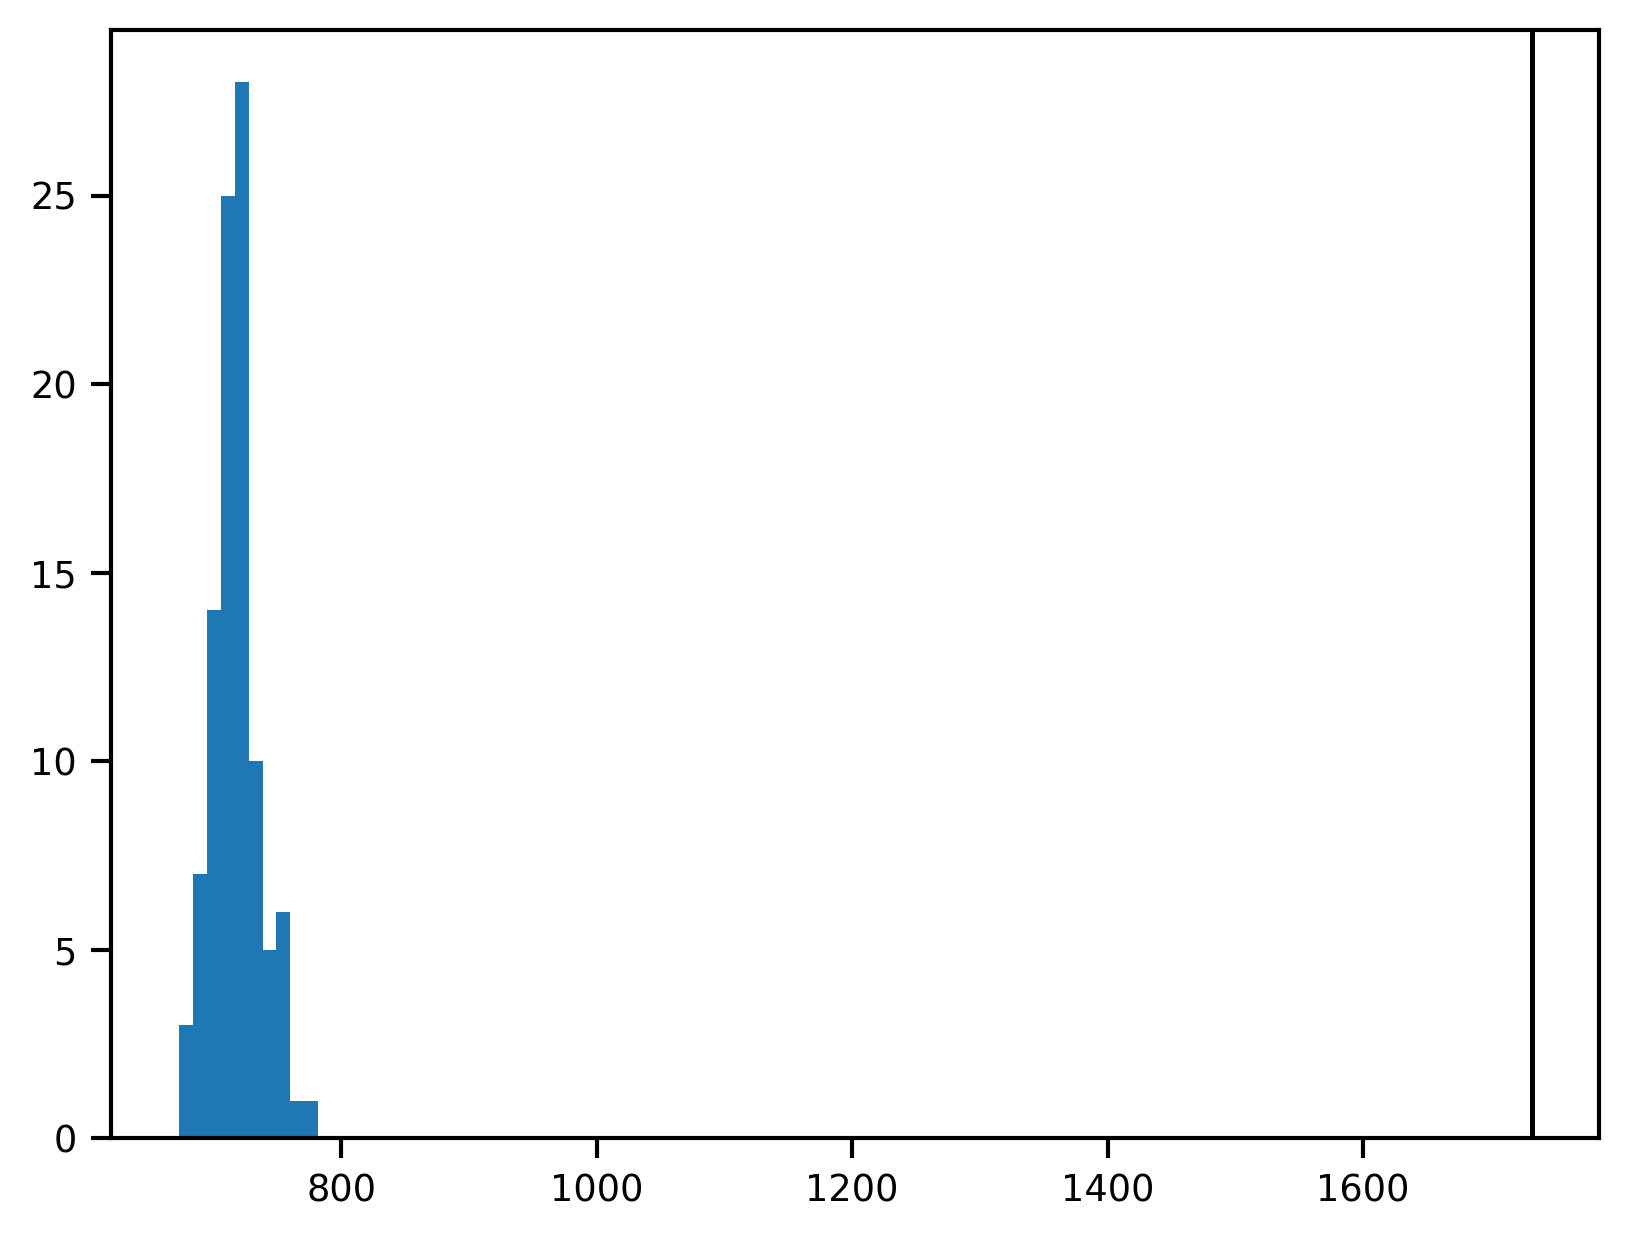

In [23]:
_perm = plasmid_phage_perm_histogram2d
_obs = plasmid_phage_obs_histogram

obs_num_clust_ge3 = _obs.iloc[::-1].cumsum().loc[3]
null_num_clust_ge3 = _perm.iloc[:, ::-1].cumsum(1)[3]

plt.hist(null_num_clust_ge3)
plt.axvline(obs_num_clust_ge3, color="k")

d = pd.DataFrame(
    dict(
        obs=_obs.iloc[::-1].cumsum().iloc[::-1],
        perm=_perm.iloc[:, ::-1].cumsum(1).iloc[:, ::-1].mean(),
    )
).assign(ratio=lambda x: x.obs / x.perm)
d